# On-the-fly mapping exposure calculator (Radio astronomy)



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as pl

from astropy.wcs import WCS
from scipy import constants

import cygrid

np.set_printoptions(precision=1)

In [3]:
def gaincurve(elev, a0, a1, a2):
    '''
    Radio telescope sensitivity is usually a function of elevation (parametrized as parabula).
    '''
    return a0 + a1 * elev + a2 * elev * elev


def dv_to_df(restfreq, velo_kms):
    '''
    Convert velocity resolution to frequency resolution.
    '''
    return restfreq * velo_kms * 1.e3 / constants.c


def setup_header(mapcenter, mapsize, beamsize_fwhm):
    '''
    Produce a FITS header that contains the target field.
    '''
    
    # define target grid (via fits header according to WCS convention)
    # a good pixel size is a third of the FWHM of the PSF (avoids aliasing)
    pixsize = beamsize_fwhm / 3.
    dnaxis1 = int(mapsize[0] / pixsize)
    dnaxis2 = int(mapsize[1] / pixsize)

    header = {
        'NAXIS': 2,
        'NAXIS1': dnaxis1,
        'NAXIS2': dnaxis2,
        'CTYPE1': 'RA---SIN',
        'CTYPE2': 'DEC--SIN',
        'CUNIT1': 'deg',
        'CUNIT2': 'deg',
        'CDELT1': -pixsize,
        'CDELT2': pixsize,
        'CRPIX1': (dnaxis1 + 1) / 2.,
        'CRPIX2': (dnaxis2 + 1) / 2.,
        'CRVAL1': mapcenter[0],
        'CRVAL2': mapcenter[1],
        }
    
    return header

## Introduction: Position switching
Let's start with an illustrative example, that shows how exposure calculation is done for a pointed observation (position switch). Usually, the backend provides the measured (spectral) intensities, $P$, in an uncalibrated fashion, e.g., in units of counts. Therefore one needs to derive a conversion factor. Furthermore, one has to remove the influence of the system bandpass (frequency-dependent gain). Both problems can be solved with the so-called position-switching technique:

\begin{equation}
T = T_\mathrm{sys}\frac{P_\mathrm{on} - P_\mathrm{ref}}{P_\mathrm{ref}}\,.
\end{equation}

The system temperature, $T_\mathrm{sys}$, is a property of the receiver, which determines the base noise level. It depends on the receiver noise itself, but also has conributions from ground and atmosphere, as well as astronomical background (Galactic continuum, CMB). The noise level, $\Delta T$, of the derived spectral intensity, $T$, will decrease the longer one integrates (radiometer equation):

\begin{equation}
\Delta T = \frac{T_\mathrm{sys}}{\sqrt{\tau\Delta f}}\,.
\end{equation}

However, for position switching one divides the On and Off spectra, which increases the noise by a factor of $\sqrt{2}$. This factor is absorbed by the fact, that one often has two polarization channels available, which can be averaged.

### Example: observation of NH3 lines at 23.7 GHz (at Effelsberg)
For this one would use a K-band receiver, which has about 60 K system temperature (zenith). For non-zenith observations, the airmass will increase the effective system temperature, depending on the atmospheric opacity, $\tau$.

In [4]:
dual_pol = True
restfreq = 23.7e9  # Hz
opacity = 0.07  # assume reasonably good weather
Tsys_zenith = 60.

Atmospheric temperature is approximately given by ambient temperature at ground.

In [5]:
T_amb = 290.  # K
T_atm = T_amb - 17.

Calculate telescope sensitivity (aka Kelvins per Jansky).

In [6]:
Gamma = 1.12  # K/Jy
eta_MB = 0.79  # main beam efficiency
Gamma_MB = Gamma / eta_MB

The conversion between antenna temperatures and main-beam brightness temperatures is given by

In [7]:
Ta_to_Tb = 1. / eta_MB

Define spectrometer properties

In [8]:
nchan = 2 ** 16  # 64 k
bandwidth = 5e8  # 500 MHz
spec_reso = bandwidth / nchan * 1.16  # true spectral resolution 16% worse than channel width
print('spec_reso = {:.1f} kHz'.format(spec_reso * 1.e-3))

spec_reso = 8.9 kHz


If a certain velocity resolution is desired, we first have to infer the desired spectral resolution.

In [9]:
desired_vel_resolution = 1.  # km/s
desired_freq_resolution = dv_to_df(restfreq, desired_vel_resolution)
print('desired_freq_resolution = {:.1f} kHz'.format(desired_freq_resolution * 1.e-3))

desired_freq_resolution = 79.1 kHz


This means, we can bin the original spectrum by a factor of

In [10]:
smooth_nbin = int(desired_freq_resolution / spec_reso + 0.5)

which will further decrease the noise.

In [11]:
print('smooth_nbin', smooth_nbin)

smooth_nbin 9


#### Case 1: Calculate the noise after a certain integration time. The result will depend on the elevation of the source (because different airmasses modify $T_\mathrm{sys}$).

In [12]:
exposure = 60.  # seconds
elevations = np.array([10, 20, 30, 40, 50, 60, 90])
AM = 1. / np.sin(np.radians(elevations))

gain_correction = gaincurve(elevations, 0.954, 3.19E-3, -5.42E-5)

Note, Tsys is higher for low elevation (more air mass).

In [13]:
Tsys_corr = Tsys_zenith + T_atm * (np.exp(opacity * AM) - np.exp(opacity * 1))
print('Tsys_corr', Tsys_corr)
# Tsys_corr = Tsys_zenith + opacity * T_atm * (AM - 1)  # approximate formula, for small opacity * AM
# print(Tsys_corr)

Tsys_corr [ 175.7  102.2   81.2   71.6   66.3   63.2   60. ]


Calculate raw $T_\mathrm{A}$ noise:

In [14]:
Ta_rms = Tsys_corr / np.sqrt(spec_reso * smooth_nbin * exposure)

For dual polarization observations, we can divide by $\sqrt{2}$.

In [15]:
if dual_pol:
    Ta_rms /= np.sqrt(2.)

We also have to account for the position switch (division by noisy reference spectrum).

In [16]:
Ta_rms *= np.sqrt(2.)

Finally, we convert to main-beam brightness temperature, $\Delta T_\mathrm{B}$, and flux-density, $\Delta S$, noise:

In [17]:
Tb_rms = Ta_to_Tb * Ta_rms / gain_correction
S_rms = Tb_rms / Gamma_MB

The astronomical signal is furthermore attenuated by the atmosphere. There are two ways to handle this. (a) If the signal strength is known (or can be expected to have a certain value), just apply the attenuation factor and compare to the noise levels. (b) calculate an effective noise level, by increasing Tb and flux-density noise accordingly. Here, we follow the second approach, as the true signal level is unknown. The effective RMS values are not true RMS estimates, but merely serve to indicate the impact of Earth's atmosphere on the sensitivity. Close to zenith, the effect is a few percent only, but for very low elevations, almost half of the signal is lost!

In [18]:
atm_atten = np.exp(-opacity * AM)

In [19]:
print('{0:>8s} {1:>8s} {2:>10s} {3:>10s} {4:>10s} {5:>10s} {6:>10s} {7:>10s} {8:>10s}'.format(
    'Elev', 'Airmass', 'Tsys', 'Ta RMS', 'Tb RMS', 'S RMS', 'AtmAtten', 'Tb_eff RMS', 'S_eff RMS'
    ))
print('{0:>8s} {1:>8s} {2:>10s} {3:>10s} {4:>10s} {5:>10s} {6:>10s} {7:>10s} {8:>10s}'.format(
    '[d]', '', '[K]', '[K]', '[K]', '[Jy]', '', '[K]', '[Jy]'
    ))
for idx in range(len(elevations)):
    print(
        '{0:>8.2f} {1:>8.2f} {2:>10.4f} {3:>10.4f} {4:>10.4f} '
        '{5:>10.4f} {6:>10.4f} {7:>10.4f} {8:>10.4f}'.format(
            elevations[idx], AM[idx], Tsys_corr[idx],
            Ta_rms[idx], Tb_rms[idx], S_rms[idx],
            atm_atten[idx],
            Tb_rms[idx] / atm_atten[idx], S_rms[idx] / atm_atten[idx],
            ))

print('Ta RMS = Antenna temp. noise')
print('Tb RMS = Brightness temp. noise')
print('S RMS = Flux density noise')


    Elev  Airmass       Tsys     Ta RMS     Tb RMS      S RMS   AtmAtten Tb_eff RMS  S_eff RMS
     [d]                 [K]        [K]        [K]       [Jy]                   [K]       [Jy]
   10.00     5.76   175.7436     0.0804     0.1038     0.0732     0.6682     0.1553     0.1096
   20.00     2.92   102.2078     0.0468     0.0594     0.0419     0.8149     0.0729     0.0514
   30.00     2.00    81.2300     0.0372     0.0470     0.0331     0.8694     0.0541     0.0381
   40.00     1.56    71.6143     0.0328     0.0417     0.0294     0.8968     0.0465     0.0328
   50.00     1.31    66.3269     0.0303     0.0393     0.0277     0.9127     0.0430     0.0303
   60.00     1.15    63.1879     0.0289     0.0385     0.0272     0.9224     0.0417     0.0294
   90.00     1.00    60.0000     0.0274     0.0433     0.0306     0.9324     0.0465     0.0328
Ta RMS = Antenna temp. noise
Tb RMS = Brightness temp. noise
S RMS = Flux density noise


#### Case 2: Calculate, how long we have to integrate, to reach a certain (effective) noise level.

Start with a given noise level

In [20]:
Tb_eff_rms_desired = 0.01  # 10 mK
Ta_eff_rms_desired = Tb_eff_rms_desired * gain_correction / Ta_to_Tb

Again, divide by two for dual polarization

In [21]:
exposure = (Tsys_corr / Ta_eff_rms_desired) ** 2 / (spec_reso * smooth_nbin)
if dual_pol:
    exposure /= 2.

and account for PSW (division by noisy reference spectrum)

In [22]:
exposure *= 2.

In [23]:
print('Exposure time needed to reach an effective MB brightness temperature noise level of {:.1f} mK'.format(
    Tb_eff_rms_desired * 1.e3))
print('{0:>8s} {1:>10s}'.format('Elev [d]', 'Time [min]'))
for idx in range(len(elevations)):
    print('{0:>8.2f} {1:>10.1f}'.format(
        elevations[idx], (exposure / 60.)[idx]
        ))

Exposure time needed to reach an effective MB brightness temperature noise level of 10.0 mK
Elev [d] Time [min]
   10.00      107.7
   20.00       35.3
   30.00       22.1
   40.00       17.4
   50.00       15.4
   60.00       14.8
   90.00       18.8


## On-the-fly mapping
For OTF mapping, it is not straight-forward to calculate the effective noise in the map after gridding. Therefore, we simulate the process, use cygrid to produce a map, and will measure the noise accordingly.

### Map setup
In Effelsberg, we do so-called zig-zag scanning. For position switching, one observes a reference position every $n$ scanlines. In contrast to the pointed observations, it is possible to spend a different amount of time on the reference position (this will have an impact on the degree of correlated spatial noise in the final map!). 

In [24]:
map_width, map_height = 100., 100.  # arcsec
beamsize_fwhm = 38.  # arcsec; at the frequency given in our example

The spacing between the scans should not be larger than half the beamwidth, a third is even better.

In [25]:
num_scan_lines = int(3 * map_height / beamsize_fwhm + 0.5)
print('num_scan_lines', num_scan_lines)

num_scan_lines 8


Likewise, the scan velocity must not be too high. This is determined by the sampling rate and the beam size (one wants at least three independent samples, per beam, otherwise the resulting map will have some smearing along the scan lines).

Let's calculate the maximal scan speed

In [26]:
sampling_interval = 1.  # s (== 4 x 250 ms at Effelsberg)

max_speed = beamsize_fwhm / 3 / sampling_interval
print('max_speed = {:.2f} arcsec per s'.format(max_speed))

max_speed = 12.67 arcsec per s


With this, we can calculate the minimal duration of one scan line

In [27]:
min_duration = map_width / max_speed
print('min_duration = {:.1f} s'.format(min_duration))

min_duration = 7.9 s


However, each telescope will have a duty cycle between two scan lines, which is defined by the time the telescope needs for re-positioning. At Effelsberg, this is about 15 s, which means that the duration per scanline should at least be one or two minutes, otherwise the observing efficiency would become really poor.

Choose a meaningful scanline duration

In [28]:
scanline_duration = 90.  # seconds
samples_per_scanline = int(scanline_duration / sampling_interval + 0.5)
print('samples_per_scanline', samples_per_scanline)

samples_per_scanline 90


We now have to choose the time spent on the reference position. Furthermore, it is possible to do the reference scan only after every $n$ scanlines (to save time).

Let's do a relatively long refpos integration, but only after every 2 scanlines (avoids some duty cycles).

In [29]:
refpos_duration = 90.  # seconds
refpos_interval = 2 

Such a map would need the following total observing time.

In [30]:
duty_cycle = 15.  # s
total_on_time = (scanline_duration + duty_cycle) * num_scan_lines
total_ref_time = (refpos_duration + duty_cycle) * (num_scan_lines // refpos_interval)
total_time = total_on_time + total_ref_time
print('Total time necessary for map: {:.1f} min'.format(total_time / 60.))


Total time necessary for map: 21.0 min


Now, we create the raw data. Note, the absolute value of the RMS in counts (for the P quantities) is not important, but the RMS ratio between On and Ref spectra is (the absolute number is unimportant, because it gets calibrated away in the (On-Ref/Ref) equation).

Compared to the On scan, a Ref position is integrated over 'refpos_duration', which means that noise in the Ref spectrum is $\sqrt{\texttt{refpos_duration} / \texttt{sampling_interval}}$ smaller.

To increase the noise estimate accuracy, we will produce several noise maps at once.

In [31]:
num_maps = 128

Here, a dummy $T_\mathrm{sys}$ value is used. Later, the map (and thus the RMS) can simply be scaled to match the true $T_\mathrm{sys}$.

In [32]:
dummy_tsys = 1.  

We will now create spectral noise (in arbitrary units). This must be much smaller than $T_\mathrm{sys}$ to avoid numerical problems. It is also important, that each of the raw-data spectra has an offset (the $T_\mathrm{sys}$ level in counts, if you will). If one would neglect this, one had a division by very small numbers in the line where the reduced spectra are calculated. The magnitude of the noise is furthermore tied to the $T_\mathrm{sys}$ level - it is based on the "radiometer" factor $\left(1/\sqrt{\tau\Delta f}\right)$

In [33]:
on_noise = dummy_tsys / np.sqrt(spec_reso * smooth_nbin * sampling_interval)
ref_noise = dummy_tsys / np.sqrt(spec_reso * smooth_nbin * refpos_duration)

print('on_noise = {:.2e}, ref_noise = {:.2e}'.format(on_noise, ref_noise))

reduced_specs = np.empty((num_scan_lines, samples_per_scanline, num_maps))
xcoords, ycoords = np.empty((2, num_scan_lines, samples_per_scanline))
lons = np.linspace(-map_width / 2, map_width / 2, samples_per_scanline)
lats = np.linspace(-map_height / 2, map_height / 2, num_scan_lines)

for scan_line in range(num_scan_lines):
    
    if scan_line % refpos_interval == 0:
        ref_spec = np.random.normal(0., ref_noise, num_maps) + dummy_tsys
    
    on_specs = np.random.normal(0., on_noise, (samples_per_scanline, num_maps)) + dummy_tsys    
    reduced_specs[scan_line] = dummy_tsys * (on_specs - ref_spec) / ref_spec
    
    xcoords[scan_line] = lons
    ycoords[scan_line] = np.repeat(lats[scan_line], lons.size)
   

on_noise = 3.54e-03, ref_noise = 3.73e-04


We can test this, by just plotting the "raw" data for one channel.

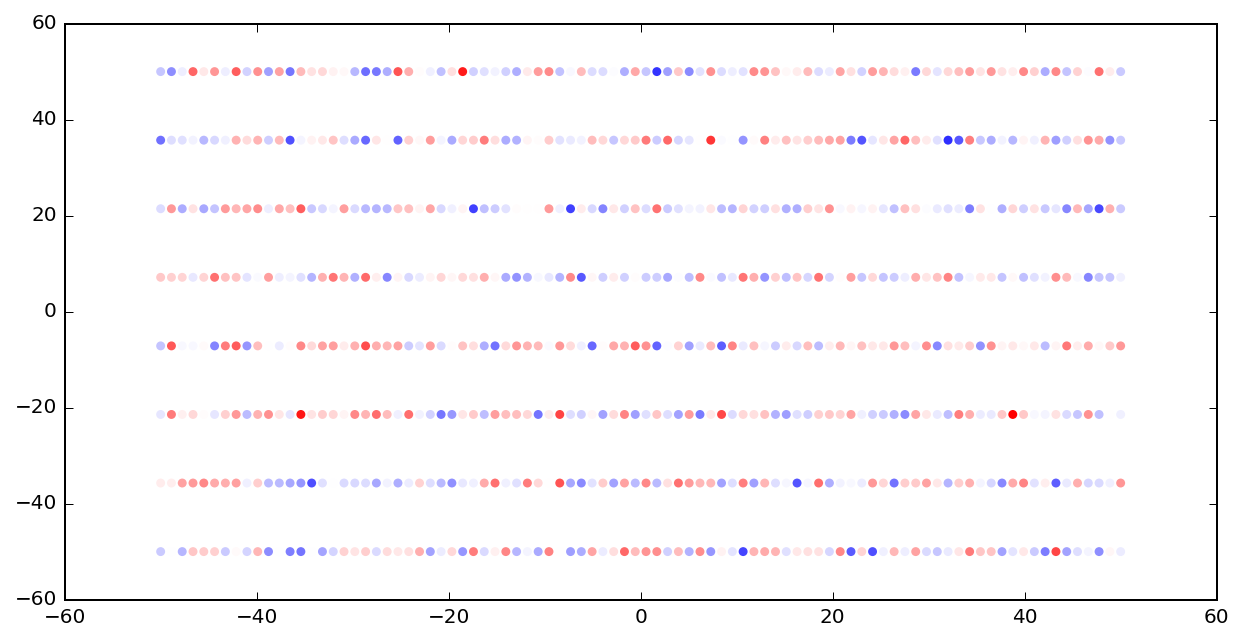

In [34]:
tmp_map = reduced_specs[..., 0]
cabs = np.max(np.abs(tmp_map))

fig = pl.figure(figsize=(10, 5))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
_ = ax.scatter(
    xcoords, ycoords, c=tmp_map, 
    cmap='bwr', edgecolor='none',
    vmin=-cabs, vmax=cabs,
    )

Now do the real gridding. First, prepare a WCS header

In [35]:
target_header = setup_header((0, 0), (map_width / 3600., map_height / 3600.), beamsize_fwhm / 3600.)

We already define a WCS object for later use in our plots:

In [36]:
target_wcs = WCS(target_header)
# print(target_header)

Setup the gridder and define kernel sizes (half the beamsize is always a good choice).

In [37]:
gridder = cygrid.WcsGrid(target_header, naxis3=num_maps)

kernelsize_fwhm = beamsize_fwhm / 2  
kernelsize_fwhm /= 3600.  # need to convert to degree
kernelsize_sigma = kernelsize_fwhm / np.sqrt(8 * np.log(2))
support_radius = 4. * kernelsize_sigma
healpix_reso = kernelsize_sigma / 2.

gridder.set_kernel(
    'gauss1d',
    (kernelsize_sigma,),
    support_radius,
    healpix_reso,
    )

The gridder needs the coordinates as flat arrays. The data to be gridded must be a 2D array (first dimension has to match the number of coordinate samples, second dimension is the number of channels/maps in the desired data cube).

In [38]:
gridder.grid(xcoords.flatten() / 3600, ycoords.flatten() / 3600, reduced_specs.reshape((-1, num_maps)))

cygrid_cube = gridder.get_datacube()

Again, as a sanity check, we plot one of the channel maps.

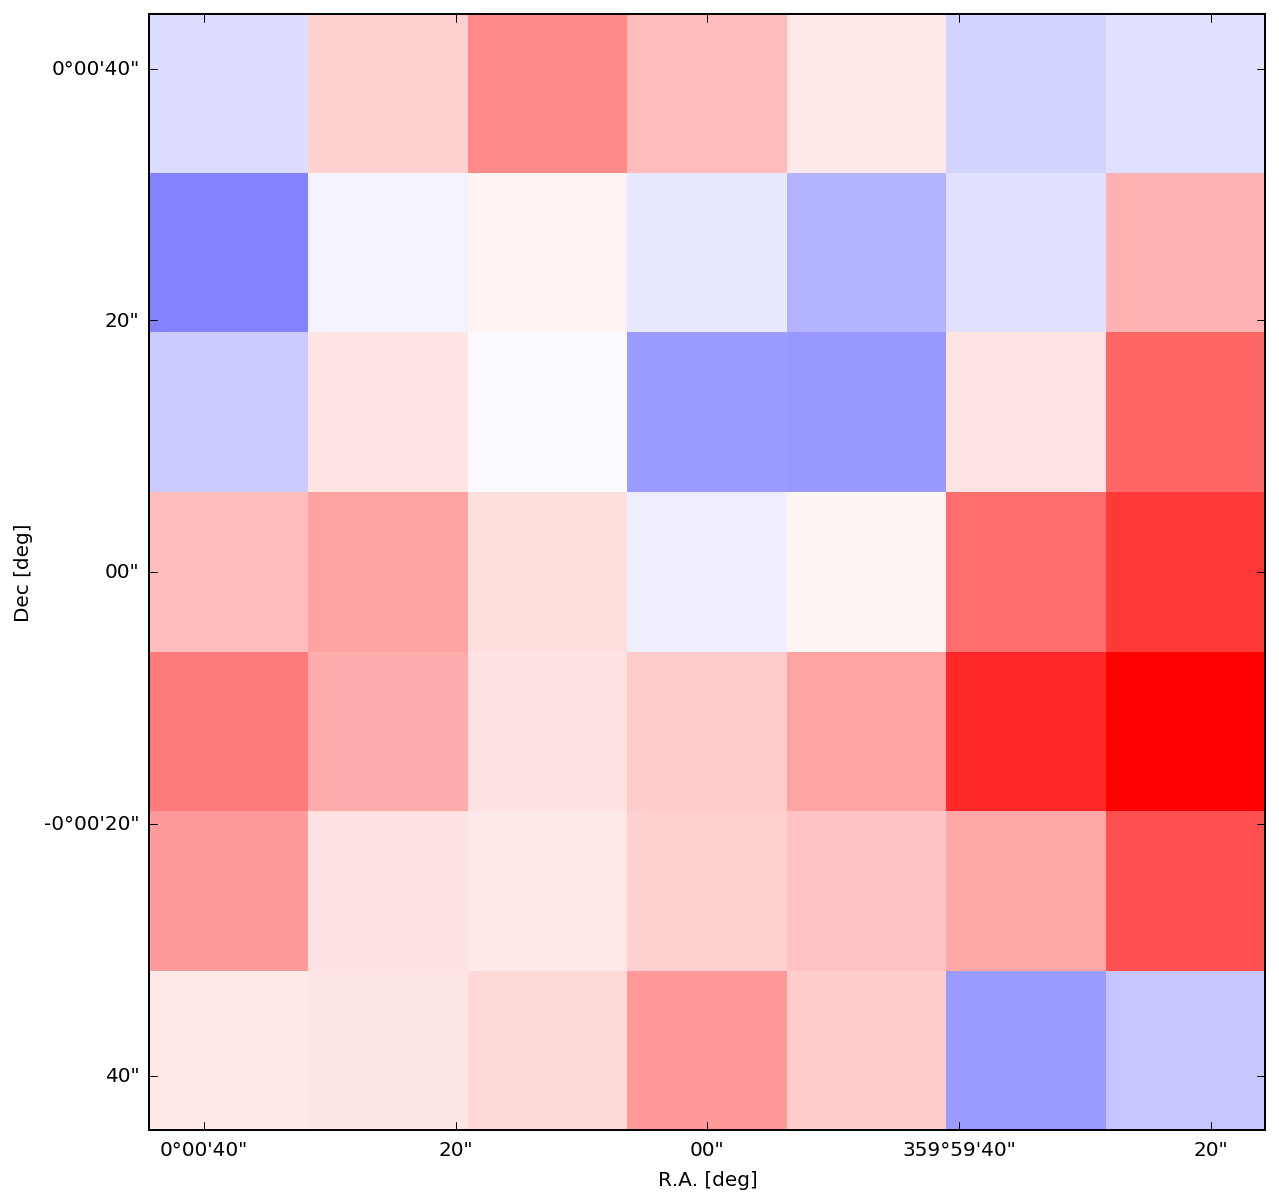

In [39]:
tmp_map = cygrid_cube[0]
cabs = np.max(np.abs(tmp_map))

fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=target_wcs.celestial)
ax.imshow(tmp_map, cmap='bwr', interpolation='nearest', origin='lower', vmin=-cabs, vmax=cabs)
lon, lat = ax.coords
lon.set_axislabel('R.A. [deg]')
lat.set_axislabel('Dec [deg]')
pl.show()

Last but not least, we can measure the noise. There are two possibilities to do this.

First, we can calculate the RMS over the full data cube.

In [40]:
rms_cube = np.std(cygrid_cube, ddof=1)

Second, we can calculate the RMS per plane (and the average over all planes)

In [41]:
rms_plane = np.mean(np.std(cygrid_cube, ddof=1, axis=(1, 2)))
print('rms_cube', rms_cube, 'rms_plane', rms_plane)

rms_cube 0.000587607 rms_plane 0.000531276


The ultimate questions is, what is the noise level in such a map, if we account for real $T_\mathrm{sys}$ and atmospheric effects, etc.

In [42]:
elevations = np.array([10, 20, 30, 40, 50, 60, 90])
AM = 1. / np.sin(np.radians(elevations))

gain_correction = gaincurve(elevations, 0.954, 3.19E-3, -5.42E-5)

Tsys_corr = Tsys_zenith + T_atm * (np.exp(opacity * AM) - np.exp(opacity * 1))
print('Tsys_corr', Tsys_corr)

Tsys_corr [ 175.7  102.2   81.2   71.6   66.3   63.2   60. ]


$T_\mathrm{A}$ noise is now the measured noise from the gridded maps multiplied with the $T_\mathrm{sys}$

In [43]:
Ta_rms = rms_cube * Tsys_corr

if dual_pol:
    Ta_rms /= np.sqrt(2.)

Note, we don't need to account for the position switch again (division by noisy reference spectrum was already performed in the reduced-spectra array creation)!

In [44]:
Tb_rms = Ta_to_Tb * Ta_rms / gain_correction
S_rms = Tb_rms / Gamma_MB

atm_atten = np.exp(-opacity * AM)

In [45]:
print('-' * 95)
print('RMS per map')
print('-' * 95)
print('{0:>8s} {1:>8s} {2:>10s} {3:>10s} {4:>10s} {5:>10s} {6:>10s} {7:>10s} {8:>10s}'.format(
    'Elev', 'Airmass', 'Tsys', 'Ta RMS', 'Tb RMS', 'S RMS', 'AtmAtten', 'Tb_eff RMS', 'S_eff RMS'
    ))
print('{0:>8s} {1:>8s} {2:>10s} {3:>10s} {4:>10s} {5:>10s} {6:>10s} {7:>10s} {8:>10s}'.format(
    '[d]', '', '[K]', '[K]', '[K]', '[Jy]', '', '[K]', '[Jy]'
    ))
for idx in range(len(elevations)):
    print(
        '{0:>8.2f} {1:>8.2f} {2:>10.4f} {3:>10.4f} {4:>10.4f} '
        '{5:>10.4f} {6:>10.4f} {7:>10.4f} {8:>10.4f}'.format(
            elevations[idx], AM[idx], Tsys_corr[idx],
            Ta_rms[idx], Tb_rms[idx], S_rms[idx],
            atm_atten[idx],
            Tb_rms[idx] / atm_atten[idx], S_rms[idx] / atm_atten[idx],
            ))

print('Ta RMS = Antenna temp. noise')
print('Tb RMS = Brightness temp. noise')
print('S RMS = Flux density noise')


-----------------------------------------------------------------------------------------------
RMS per map
-----------------------------------------------------------------------------------------------
    Elev  Airmass       Tsys     Ta RMS     Tb RMS      S RMS   AtmAtten Tb_eff RMS  S_eff RMS
     [d]                 [K]        [K]        [K]       [Jy]                   [K]       [Jy]
   10.00     5.76   175.7436     0.0730     0.0943     0.0665     0.6682     0.1411     0.0995
   20.00     2.92   102.2078     0.0425     0.0540     0.0381     0.8149     0.0662     0.0467
   30.00     2.00    81.2300     0.0338     0.0427     0.0301     0.8694     0.0491     0.0346
   40.00     1.56    71.6143     0.0298     0.0379     0.0267     0.8968     0.0422     0.0298
   50.00     1.31    66.3269     0.0276     0.0357     0.0252     0.9127     0.0391     0.0276
   60.00     1.15    63.1879     0.0263     0.0350     0.0247     0.9224     0.0379     0.0267
   90.00     1.00    60.0000     0.0

To reach the desired RMS of about 10 mK, one would hence need a factor of about 4 lower noise, which is an increase of 16 in observing time (aka 16 coverages of the map).